In [14]:
import pandas as pd
from IPython.display import HTML
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from xgboost import XGBClassifier
# Initialize and evaluate GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

import time

import scipy.stats as ss
import joblib



In [3]:
# Load the dataset
file_path = './Data/MergedData.csv'
merged_df = pd.read_csv(file_path)

/var/folders/hl/w5x9js51325d0gtv9ldxkd8c0000gn/T/ipykernel_36026/4016632151.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(file_path)


In [4]:

# Identify customers with any NULL values in any column
customers_with_nulls = merged_df[merged_df.isnull().any(axis=1)]['customer_number'].unique()

# Remove all records of these customers from the dataset
cleaned_df = merged_df[~merged_df['customer_number'].isin(customers_with_nulls)]

# Calculate the unique order count for each customer
unique_orders_per_customer = cleaned_df.groupby('customer_number')['order_number'].nunique()

# Identify customers who have placed more than 3 unique orders
customers_with_more_than_3_orders = unique_orders_per_customer[unique_orders_per_customer > 2].index

# Filter the cleaned_df to keep only those customers
filtered_cleaned_df = cleaned_df[cleaned_df['customer_number'].isin(customers_with_more_than_3_orders)]

# Calculate the number of unique PRH4 per order
unique_prh4_per_order = filtered_cleaned_df.groupby(['order_number', 'customer_number'])['PRH4'].nunique()

# Identify customers who have ordered more than 7 unique PRH4 in the same order
customers_with_more_than_7_prh4 = unique_prh4_per_order[unique_prh4_per_order >= 7].index.get_level_values('customer_number').unique()

# Remove all records of these customers from the filtered_cleaned_df
final_cleaned_df = filtered_cleaned_df[~filtered_cleaned_df['customer_number'].isin(customers_with_more_than_7_prh4)]

# Display the number of records in the final cleaned dataset
num_records_final_cleaned = final_cleaned_df.shape[0]
print(f'The number of records in the final_cleaned_df DataFrame: {num_records_final_cleaned}')

# Check the number of unique customers in the final cleaned dataframe
unique_customers_final_cleaned = final_cleaned_df['customer_number'].nunique()
print(f'The number of unique customers in the final_cleaned_df DataFrame: {unique_customers_final_cleaned}')

# Assuming df is your final DataFrame
final_cleaned_df.to_csv('./Data/final_preprocessed_data.csv', index=False)

The number of records in the final_cleaned_df DataFrame: 94995
The number of unique customers in the final_cleaned_df DataFrame: 5003


In [ ]:
# Load the dataset
preprocessed_file_path = './Data/MergedData.csv'

df = pd.read_csv(preprocessed_file_path)


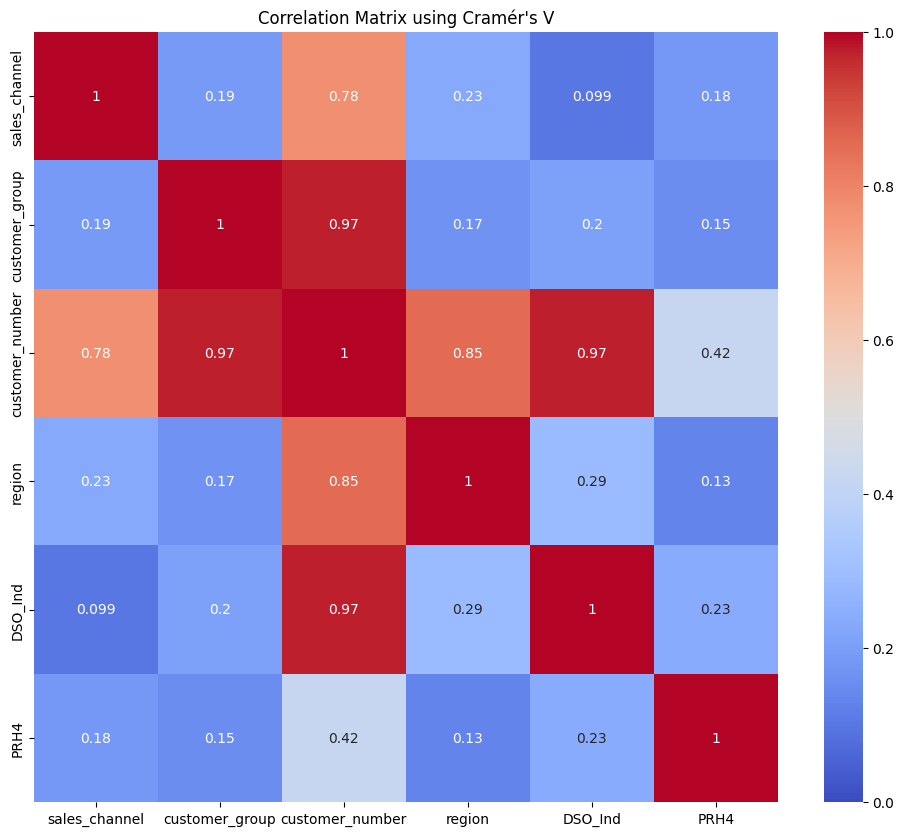

In [7]:
# Define the feature columns and the target column
feature_columns = ['sales_channel', 'customer_group', 'customer_number', 'region', 'DSO_Ind']
target_column = 'PRH4'

# Include the target column in the features for correlation calculation
all_columns = feature_columns + [target_column]

# Separate the features and the target variable
X = df[all_columns]

# One-hot encode the categorical variables
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), all_columns)
    ],
    remainder='passthrough'
)
X_encoded = column_transformer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df[target_column])

# Calculate Cramér's V for each feature with the target variable
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate the correlation matrix using Cramér's V
correlation_matrix = np.zeros((len(all_columns), len(all_columns)))
for i, feature_i in enumerate(all_columns):
    for j, feature_j in enumerate(all_columns):
        if i == j:
            correlation_matrix[i, j] = 1
        else:
            confusion_matrix = pd.crosstab(X[feature_i], X[feature_j])
            correlation_matrix[i, j] = cramers_v(confusion_matrix.values)

# Convert the correlation matrix to a DataFrame for better visualization
correlation_df = pd.DataFrame(correlation_matrix, index=all_columns, columns=all_columns)

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation Matrix using Cramér\'s V')
plt.show()


In [11]:
# Define the feature columns and the target column
feature_columns = ['sales_channel', 'customer_group', 'customer_number', 'region', 'DSO_Ind']
target_column = 'PRH4'

# Separate the features and the target variable
X = df[feature_columns]
y = df[target_column]

# One-hot encode the categorical variables
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), feature_columns)
    ],
    remainder='passthrough'
)
X = column_transformer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Function to train and evaluate a model
def evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Ensure that the labels parameter in the classification report matches the unique labels in the test set
    labels = sorted(list(set(y_test)))
    target_names = label_encoder.inverse_transform(labels)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred, labels=labels, target_names=target_names)
    
    # Display the evaluation metrics
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Precision: {precision}')
    print(f'{model_name} Recall: {recall}')
    print(f'{model_name} F1 Score: {f1}')
    print(f'{model_name} Classification Report:')
    print(report)
    print('\n')
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel as needed

# Evaluate models and collect results
results = []
results.append(evaluate_model(rf_model, "Random Forest"))
results.append(evaluate_model(xgb_model, "XGBoost"))
results.append(evaluate_model(svm_model, "SVM"))

# Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/my

Random Forest Accuracy: 0.5551344807621453
Random Forest Precision: 0.5376323191062479
Random Forest Recall: 0.5551344807621453
Random Forest F1 Score: 0.5363148218462832
Random Forest Classification Report:
                                    precision    recall  f1-score   support

           Abutments, Customizable       0.00      0.00      0.00         1
             Abutments, Edentulous       0.39      0.24      0.30       447
                    Abutments, SRA       0.35      0.16      0.22       882
                Abutments, Ti Base       0.60      0.41      0.49       401
  Abutments, single tooth + bridge       0.47      0.30      0.36       240
        Allogenic Bone Substitutes       0.49      0.36      0.42       293
      Allogenic Soft Tissue Grafts       0.33      0.08      0.12        13
               BL Healing Surgical       0.39      0.31      0.34      1882
     BLAT Ti Implants, hydrophilic       0.56      0.82      0.67      1851
        BLAT Ti Implants, stand

/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/my

XGBoost Accuracy: 0.48292015369229957
XGBoost Precision: 0.4719278995267456
XGBoost Recall: 0.48292015369229957
XGBoost F1 Score: 0.43473347322050104
XGBoost Classification Report:
                                    precision    recall  f1-score   support

           Abutments, Customizable       0.00      0.00      0.00         1
             Abutments, Edentulous       0.41      0.06      0.11       447
                    Abutments, SRA       0.42      0.06      0.11       882
                Abutments, Ti Base       0.71      0.29      0.41       401
  Abutments, single tooth + bridge       0.44      0.03      0.06       240
        Allogenic Bone Substitutes       0.39      0.08      0.14       293
      Allogenic Soft Tissue Grafts       0.50      0.15      0.24        13
               BL Healing Surgical       0.36      0.22      0.27      1882
     BLAT Ti Implants, hydrophilic       0.46      0.72      0.56      1851
        BLAT Ti Implants, standard       0.51      0.67   

/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/my

In [12]:
# Define the feature columns and the target column
feature_columns = ['sales_channel', 'customer_group', 'customer_number', 'region', 'DSO_Ind']
target_column = 'PRH4'

# Separate the features and the target variable
X = df[feature_columns]
y = df[target_column]

# One-hot encode the categorical variables
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), feature_columns)
    ],
    remainder='passthrough'
)
X = column_transformer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Function to train and evaluate a model
def evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Ensure that the labels parameter in the classification report matches the unique labels in the test set
    labels = sorted(list(set(y_test)))
    target_names = label_encoder.inverse_transform(labels)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred, labels=labels, target_names=target_names)
    
    # Display the evaluation metrics
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Precision: {precision}')
    print(f'{model_name} Recall: {recall}')
    print(f'{model_name} F1 Score: {f1}')
    print(f'{model_name} Classification Report:')
    print(report)
    print('\n')
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel as needed

# Evaluate models and collect results
results = []
results.append(evaluate_model(rf_model, "Random Forest"))
results.append(evaluate_model(xgb_model, "XGBoost"))
results.append(evaluate_model(svm_model, "SVM"))

# Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/my

Random Forest Accuracy: 0.5551344807621453
Random Forest Precision: 0.5376323191062479
Random Forest Recall: 0.5551344807621453
Random Forest F1 Score: 0.5363148218462832
Random Forest Classification Report:
                                    precision    recall  f1-score   support

           Abutments, Customizable       0.00      0.00      0.00         1
             Abutments, Edentulous       0.39      0.24      0.30       447
                    Abutments, SRA       0.35      0.16      0.22       882
                Abutments, Ti Base       0.60      0.41      0.49       401
  Abutments, single tooth + bridge       0.47      0.30      0.36       240
        Allogenic Bone Substitutes       0.49      0.36      0.42       293
      Allogenic Soft Tissue Grafts       0.33      0.08      0.12        13
               BL Healing Surgical       0.39      0.31      0.34      1882
     BLAT Ti Implants, hydrophilic       0.56      0.82      0.67      1851
        BLAT Ti Implants, stand

/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/my

XGBoost Accuracy: 0.48292015369229957
XGBoost Precision: 0.4719278995267456
XGBoost Recall: 0.48292015369229957
XGBoost F1 Score: 0.43473347322050104
XGBoost Classification Report:
                                    precision    recall  f1-score   support

           Abutments, Customizable       0.00      0.00      0.00         1
             Abutments, Edentulous       0.41      0.06      0.11       447
                    Abutments, SRA       0.42      0.06      0.11       882
                Abutments, Ti Base       0.71      0.29      0.41       401
  Abutments, single tooth + bridge       0.44      0.03      0.06       240
        Allogenic Bone Substitutes       0.39      0.08      0.14       293
      Allogenic Soft Tissue Grafts       0.50      0.15      0.24        13
               BL Healing Surgical       0.36      0.22      0.27      1882
     BLAT Ti Implants, hydrophilic       0.46      0.72      0.56      1851
        BLAT Ti Implants, standard       0.51      0.67   

/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/my

In [13]:

# Load your DataFrame
df = final_cleaned_df

# Define the feature columns and the target column
feature_columns = ['sales_channel', 'customer_group', 'customer_number', 'region', 'DSO_Ind']
target_column = 'PRH4'

# Separate the features and the target variable
X = df[feature_columns]
y = df[target_column]

# One-hot encode the categorical variables
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), feature_columns)
    ],
    remainder='passthrough'
)
X = column_transformer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for Random Forest:")
print(best_params)

# Evaluate the best model
y_pred = best_rf_model.predict(X_test)

# Ensure that the labels parameter in the classification report matches the unique labels in the test set
labels = sorted(list(set(y_test)))
target_names = label_encoder.inverse_transform(labels)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred, labels=labels, target_names=target_names)

# Display the evaluation metrics
print(f'Random Forest - Best Model Evaluation Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Classification Report:')
print(report)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth

/Users/sachin/myenv_1/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 5.8min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.2min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.2min


KeyboardInterrupt: 

In [15]:
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load your DataFrame
df = final_cleaned_df

# Define the feature columns and the target column
feature_columns = ['sales_channel', 'customer_group', 'customer_number', 'region', 'DSO_Ind']
target_column = 'PRH4'

# Separate the features and the target variable
X = df[feature_columns]
y = df[target_column]

# One-hot encode the categorical variables
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), feature_columns)
    ],
    remainder='passthrough'
)
X = column_transformer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)

# Ensure that the labels parameter in the classification report matches the unique labels in the test set
labels = sorted(list(set(y_test)))
target_names = label_encoder.inverse_transform(labels)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred, labels=labels, target_names=target_names)

# Display the evaluation metrics
print(f'Random Forest - Model Evaluation Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Classification Report:')
print(report)

# Save the Random Forest model to the results folder
results_dir = 'Results'
os.makedirs(results_dir, exist_ok=True)
model_path = os.path.join(results_dir, 'random_forest_model.joblib')
joblib.dump(rf_model, model_path)
print(f'Model saved to {model_path}')


/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/myenv_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sachin/my

Random Forest - Model Evaluation Metrics:
Accuracy: 0.5551344807621453
Precision: 0.5376323191062479
Recall: 0.5551344807621453
F1 Score: 0.5363148218462832
Classification Report:
                                    precision    recall  f1-score   support

           Abutments, Customizable       0.00      0.00      0.00         1
             Abutments, Edentulous       0.39      0.24      0.30       447
                    Abutments, SRA       0.35      0.16      0.22       882
                Abutments, Ti Base       0.60      0.41      0.49       401
  Abutments, single tooth + bridge       0.47      0.30      0.36       240
        Allogenic Bone Substitutes       0.49      0.36      0.42       293
      Allogenic Soft Tissue Grafts       0.33      0.08      0.12        13
               BL Healing Surgical       0.39      0.31      0.34      1882
     BLAT Ti Implants, hydrophilic       0.56      0.82      0.67      1851
        BLAT Ti Implants, standard       0.60      0.79    